In [1]:
! pip install langchain_openai langchain langchain_core langchain_community -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.5/438.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: langchain_core
    Found existing installation: langchain-core 0.3.60
    Uninstalling langchain-core-0.3.60:
      Successfully uninstalled langchain-core-0.3.60


In [4]:
from pydantic import Field
currentTime: str = Field(description="当前时间")
currentTime

FieldInfo(annotation=NoneType, required=True, description='当前时间')

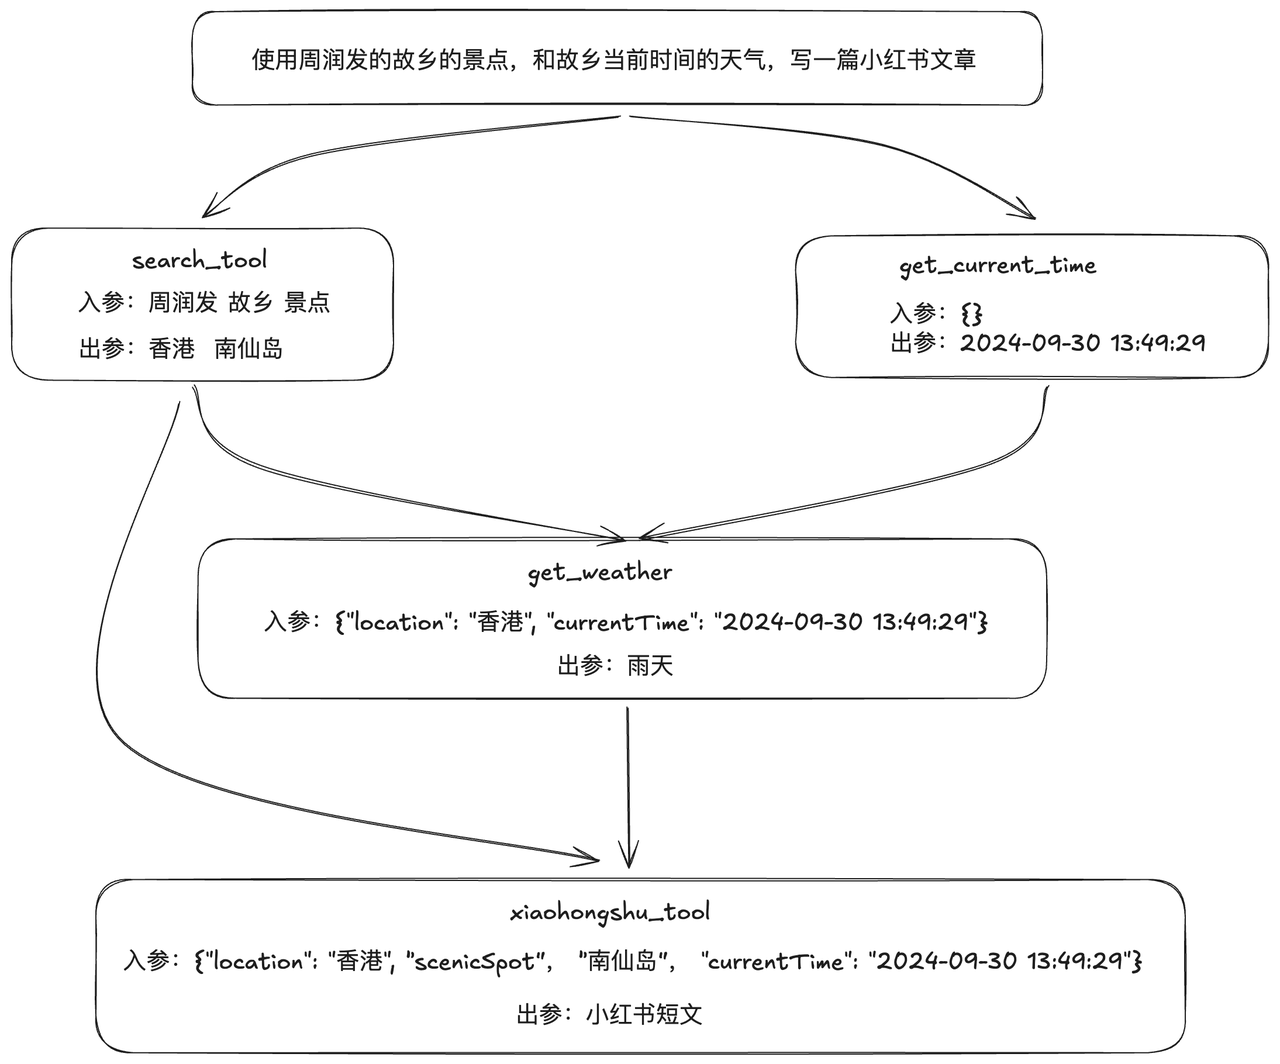

In [7]:
from langchain_core.tools import tool
import random
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.memory import ConversationBufferMemory
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools import TavilySearchResults
import datetime
from google.colab import userdata

import os
os.environ["OPENAI_API_BASE"] = userdata.get('OPENAI_API_BASE')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')


class ConfigDict(BaseModel):
    currentTime: str = Field(description="当前时间")
    location: str = Field(description="城市名")

@tool('get_weather', args_schema=ConfigDict)
def get_weather(location: str, currentTime: str):
    """获取某个城市的天气"""
    # 随机选择天气
    weather = random.choice(['晴天', '雨天'])
    return f"{location}当前时间{currentTime}的天气是{weather}"

search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    name="search_tool",
    description="获取外界知识的搜索工具"
)

class XiaohongshuParams(BaseModel):
    location: str = Field(description="城市名")
    scenicSpot: str = Field(description="景点名")
    weather: str = Field(description="天气")

@tool('xiaohongshu_tool', args_schema=XiaohongshuParams)
def xiaohongshu_tool(location: str, scenicSpot: str, weather: str):
    """小红书写手"""
    llm = ChatOpenAI(model="qwen2.5-72b-instruct", temperature=0)
    res = llm.invoke([{
      "role": "system",
      "content": """
        你的任务是以小红书博主的文章结构，以我给出的主题写一篇帖子推荐。
        你的回答应包括使用表情符号来增加趣味和互动，以及与每个段落相匹配的图片。
        请以一个引人入胜的介绍开始，为你的推荐设置基调。然后，提供至少三个与主题相关的段落，突出它们的独特特点和吸引力。
        在你的写作中使用表情符号，使它更加引人入胜和有趣。对于每个段落，请提供一个与描述内容相匹配的图片。
        这些图片应该视觉上吸引人，并帮助你的描述更加生动形象。我给出的主题是：
      """
    }, {
      "role": "user",
      "content": f"城市：{location}。景点：{scenicSpot}。天气：{weather}"
    }])

    return res.content

@tool
def get_current_time():
    """获取当前时间"""
    now = datetime.datetime.now()
    return now.strftime("%Y-%m-%d %H:%M:%S")


# 定义工具列表，包含get_user_age工具
tools = [get_weather, search_tool, xiaohongshu_tool, get_current_time]

# 初始化ChatOpenAI模型，使用qwen2.5-72b-instruct模型，温度设置为0
model = ChatOpenAI(model="qwen2.5-72b-instruct", temperature=0)

# 定义聊天提示模板
prompt = ChatPromptTemplate.from_messages(
    [
        ("placeholder", "{chat_history}"),  # 占位符，用于存储聊天历史
        ("human", "{input}"),  # 用户输入
        ("placeholder", "{agent_scratchpad}"),  # 占位符，用于存储代理的临时笔记
    ]
)

# 创建工具调用代理
agent = create_tool_calling_agent(model, tools, prompt)

# 创建代理执行器，将代理、工具和记忆对象结合起来
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True
)

result = agent_executor.invoke({"input": "使用马斯克的故乡的景点，和故乡当前时间的天气，写一篇小红书文章?"})
print(result)
print(result['output'])



> Entering new AgentExecutor chain...

Invoking: `search_tool` with `{'query': '马斯克 故乡 景点'}`


[{'title': '现实很骨感—— 访南非马斯克故乡约翰内斯堡和曼德拉故居', 'url': 'https://zhuanlan.zhihu.com/p/31648037125', 'content': '从马斯克的故乡——南非最大的城市约翰内斯堡（Johannesburg）向西南开出半个小时，眼前的景象从高楼变成了无数低矮的平房，密密麻麻地聚在一起。', 'score': 0.75049835}, {'title': '一家三口来到世界首富马斯克故乡比勒陀利亚，顺便参观南非总统府', 'url': 'https://www.bilibili.com/video/BV1SC4y1L7p2/', 'content': '一家三口来到世界首富马斯克故乡比勒陀利亚，顺便参观南非总统府. 杰森纪实. 相关推荐. 查看更多. 南非圣卢西亚野生动物保护区旅游遭遇野象，游客们吓.', 'score': 0.6612456}, {'title': '一家三口来到世界首富马斯克故乡比勒陀利亚，顺便参观南非总统府,旅游,旅拍体验,好看视频', 'url': 'https://haokan.baidu.com/v?pd=wisenatural&vid=9183088315365676438', 'content': '一家三口来到世界首富马斯克故乡比勒陀利亚，顺便参观南非总统府,本视频由杰森纪实人文提供,9143次播放,好看视频是由百度团队打造的集内涵和颜值于一身的专业短视频聚合平台', 'score': 0.65835214}, {'title': '马斯克故乡与他谈条件：星链想进入特斯拉需建电池厂 - 新浪财经', 'url': 'https://finance.sina.com.cn/roll/2024-12-31/doc-inecicef2913548.shtml', 'content': '12月31消息，亿万富翁埃隆·马斯克（Elon Musk）正在将其在美国新获得的政治影响力延伸到故乡南非。 据报道，SpaceX首席执行官马斯克最近与南非总统西里尔·', 'score': 0.6

In [6]:
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.memory import ConversationBufferMemory
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import datetime

from google.colab import userdata

import os
os.environ["OPENAI_API_BASE"] = userdata.get('OPENAI_API_BASE')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# 初始化ChatOpenAI模型，使用qwen2.5-72b-instruct模型，温度设置为0
model = ChatOpenAI(model="qwen2.5-72b-instruct", temperature=0)

# 定义一个工具函数，用于获取用户的年龄
@tool
def get_user_age(name: str) -> str:
    """使用这个工具来查找用户的年龄。"""
    # 这是一个占位符，实际实现中会根据用户名返回年龄
    if "bob" in name.lower():
        return "42 years old"
    return "41 years old"

@tool
def get_text_by_age(age: str) -> str:
    """使用这个工具获取某个数字的幸运标语"""
    if age == "42":
        return "我是好孩子" + age
    elif age == "41":
        return "我是小朋友" + age
    return "我是大笨蛋" + age

@tool
def get_current_time():
    """获取当前时间。"""
    now = datetime.datetime.now()
    return now.strftime("%Y-%m-%d %H:%M:%S")

# 定义工具列表，包含get_user_age工具
tools = [get_user_age, get_current_time, get_text_by_age]

# 定义聊天提示模板
prompt = ChatPromptTemplate.from_messages(
    [
        ("placeholder", "{chat_history}"),  # 占位符，用于存储聊天历史
        ("human", "{input}"),  # 用户输入
        ("placeholder", "{agent_scratchpad}"),  # 占位符，用于存储代理的临时笔记
    ]
)

# 创建工具调用代理
agent = create_tool_calling_agent(model, tools, prompt)

# 实例化记忆对象，用于存储对话历史
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# 创建代理执行器，将代理、工具和记忆对象结合起来
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    memory=memory,  # 将记忆对象传递给执行器
    verbose=True
)

# # 验证代理是否可以使用工具
# res1 = agent_executor.invoke({"input": "hi! my name is bob what is my age?"})
# print(res1)
# print(res1['output'])
# print()

# # 验证代理是否可以访问对话历史
# # 代理应该能够回答用户的名字是bob
# res2 = agent_executor.invoke({"input": "do you remember my name?"})
# print(res2)
# print(res2['output'])

# print()
# res3 = agent_executor.invoke({"input": "当前时间是?"})
# print(res3)
# print(res3['output'])

res3 = agent_executor.invoke({"input": "我是bob， 我的年龄 的幸运标语 和 当前时间 拼出来的字符串是?"})
print(res3)
print(res3['output'])

<ipython-input-6-7c7c36b10665>:57: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)




> Entering new AgentExecutor chain...

Invoking: `get_user_age` with `{'name': 'bob'}`


42 years old
Invoking: `get_text_by_age` with `{'age': '42'}`


我是好孩子42
Invoking: `get_current_time` with `{}`


2025-06-02 10:35:16将你的年龄的幸运标语和当前时间拼成一个字符串，结果是"我是好孩子422025-06-02 10:35:16".

> Finished chain.
{'input': '我是bob， 我的年龄 的幸运标语 和 当前时间 拼出来的字符串是?', 'chat_history': [HumanMessage(content='我是bob， 我的年龄 的幸运标语 和 当前时间 拼出来的字符串是?', additional_kwargs={}, response_metadata={}), AIMessage(content='将你的年龄的幸运标语和当前时间拼成一个字符串，结果是"我是好孩子422025-06-02 10:35:16".', additional_kwargs={}, response_metadata={})], 'output': '将你的年龄的幸运标语和当前时间拼成一个字符串，结果是"我是好孩子422025-06-02 10:35:16".'}
将你的年龄的幸运标语和当前时间拼成一个字符串，结果是"我是好孩子422025-06-02 10:35:16".
